# Data preparation

In [21]:
import pandas as pd

data = pd.read_csv('https://raw.githubusercontent.com/alexeygrigorev/mlbookcamp-code/master/chapter-02-car-price/data.csv')
data = data[[
    'Make', 'Model', 'Year', 'Engine HP', 'Engine Cylinders',
    'Transmission Type', 'Vehicle Style', 'highway MPG', 'city mpg',
    'MSRP'
]]

In [22]:
data.columns = data.columns.str.replace(' ', '_').str.lower()

In [30]:
data.fillna(0, inplace=True)
data.rename({'msrp': 'price'}, axis='columns', inplace=True)

In [31]:
data.columns

Index(['make', 'model', 'year', 'engine_hp', 'engine_cylinders',
       'transmission_type', 'vehicle_style', 'highway_mpg', 'city_mpg',
       'price'],
      dtype='object')

# Question 1

<Axes: >

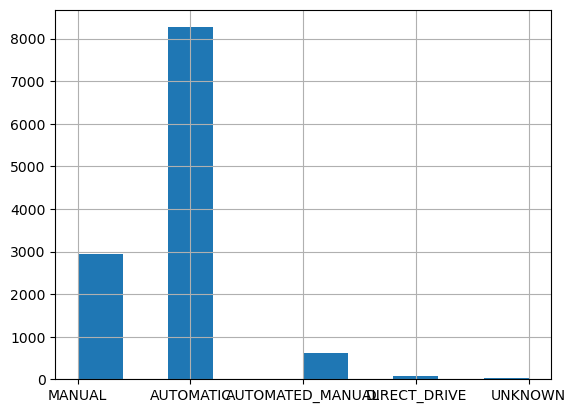

In [32]:
data['transmission_type'].hist() #AUTOMATIC

# Question 2

In [33]:
data[['year', 'engine_hp', 'engine_cylinders', 'highway_mpg', 'city_mpg']].corr()
# highway_mpg and city_mpg

,year,engine_hp,engine_cylinders,highway_mpg,city_mpg
year,1.000000,0.338714,-0.040708,0.258240,0.198171
engine_hp,0.338714,1.000000,0.774851,-0.415707,-0.424918
engine_cylinders,-0.040708,0.774851,1.000000,-0.614541,-0.587306
highway_mpg,0.258240,-0.415707,-0.614541,1.000000,0.886829
city_mpg,0.198171,-0.424918,-0.587306,0.886829,1.000000


# Question 3

In [37]:
data['above_average'] = data['price'] > data['price'].mean()
data['above_average'] = data['above_average'].astype(int)

In [41]:
from sklearn.model_selection import train_test_split
data_train, data_test = train_test_split(data, random_state=42, test_size=0.2)
data_train, data_val = train_test_split(data_train, random_state=42, test_size=0.25)

In [44]:
from sklearn.metrics import mutual_info_score

cat_feat = ['make', 'model', 'transmission_type', 'vehicle_style']

# model
for cat_feat_i in cat_feat:
    print(cat_feat_i, mutual_info_score(data_train['above_average'], data_train[cat_feat_i]))

make 0.23976875439118345
model 0.46234389209653004
transmission_type 0.020957541896301862
vehicle_style 0.0841430195677944


# Question 4

In [106]:
from sklearn.linear_model import LogisticRegression
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import accuracy_score

X_train = data_train.drop(["price", "above_average"], axis=1)
y_train = data_train["above_average"]

enc = ColumnTransformer(
        transformers=[
            ("one-hot-encode", OneHotEncoder(), ["make", "model", "transmission_type", "vehicle_style"]),
        ]
    )

model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

X_val = data_val.drop(["price", "above_average"], axis=1)
y_val = data_val["above_average"]

enc.fit(data.drop(["price", "above_average"], axis=1))
model.fit(enc.transform(X_train), y_train)

acc = accuracy_score(model.predict(enc.transform(X_val)), y_val)
print(acc)

0.9341166596726815


# Question 5

In [92]:
for col in data.columns.drop(["price", "above_average"]):
    print("Column excluded: ", col)
    
    X_train = data_train.drop([col,"price", "above_average"], axis=1)
    y_train = data_train["above_average"]

    enc_columns = ["make", "model", "transmission_type", "vehicle_style"]

    if col in enc_columns:
         enc_columns.remove(col)

    enc = ColumnTransformer(
            transformers=[
                ("one-hot-encode", OneHotEncoder(),  enc_columns),
            ]
        )

    model = LogisticRegression(solver='liblinear', C=10, max_iter=1000, random_state=42)

    X_val = data_val.drop([col, "price", "above_average"], axis=1)
    y_val = data_val["above_average"]

    enc.fit(data.drop([col, "price", "above_average"], axis=1))
    model.fit(enc.transform(X_train), y_train)

    new_acc = accuracy_score(model.predict(enc.transform(X_val)), y_val)
    print(acc-new_acc)

# transmission_type

Column excluded:  make
0.002937473772555599
Column excluded:  model
0.0809903483004617
Column excluded:  year
0.0
Column excluded:  engine_hp
0.0
Column excluded:  engine_cylinders
0.0
Column excluded:  transmission_type
-0.0008392782207301552
Column excluded:  vehicle_style
0.011330255979857373
Column excluded:  highway_mpg
0.0
Column excluded:  city_mpg
0.0


# Question 6

In [105]:
from sklearn.linear_model import Ridge
from sklearn.compose import ColumnTransformer
from sklearn.preprocessing import OneHotEncoder
from sklearn.metrics import mean_squared_error
import numpy as np

X_train = data_train.drop(["price", "above_average"], axis=1)
y_train = np.log(data_train["price"])

enc = ColumnTransformer(
    transformers=[
        ("one-hot-encode", OneHotEncoder(), ["make", "model", "transmission_type", "vehicle_style"]),
    ]
)

X_val = data_val.drop(["price", "above_average"], axis=1)
y_val = np.log(data_val["price"])

enc.fit(data.drop(["price", "above_average"], axis=1))

for alpha in [0, 0.01, 0.1, 1, 10]:
    model = Ridge(solver='sag', random_state=42, alpha=alpha)
    model.fit(enc.transform(X_train), y_train)
    acc = mean_squared_error(model.predict(enc.transform(X_val)), y_val, squared=False)
    print(alpha, round(acc, 3))

# 0.1

0 0.283
0.01 0.28
0.1 0.278
1 0.33
10 0.587
